<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# A Tutorial on Coupling the River Bed Dynamics and Overland Flow Components

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This notebook illustrates the process of running the River Bed Dynamics component, coupled with the 2D deAlmeida Overland Flow component, on an initially flat riverbed that receives an excess sediment supply. It then demonstrates how the bed slope is continuously adjusted in both time and space until a new bed elevation equilibrium is reached. For demonstration purposes, we have simulated an event that lasts one day. However, the code can be modified (by altering the commented variables) to extend the simulation until equilibrium is achieved.

First, let's import the necessary libraries and modules:

In [1]:
import copy

import matplotlib.cm as cm
import numpy as np
from IPython.display import clear_output, display
from matplotlib import pyplot as plt

from landlab import imshow_grid
from landlab.components import OverlandFlow, RiverBedDynamics
from landlab.grid.mappers import map_mean_of_link_nodes_to_link
from landlab.io import read_esri_ascii

Next, let's define some numerical simulation parameters, time control settings, filenames for accessing the grain size distribution, the digital elevation model (DEM), and set boundary conditions.

In [2]:
# ASCII raster DEM containing the bed surface elevation
zDEM = "bedElevationDEM.asc"

# ASCII file containing grain size distribution
gsd = np.loadtxt("bed_gsd.txt")

# Elapsed time (sec)
t = 0

# Elapsed time when getting initial conditions (sec)
t0 = 0

# Maximum time step in sec
max_dt = 5

# Maximum simulation time (sec)
sim_max_t = 86400 + max_dt # To reach eq use im_max_t = 60 * 86400 + max_dt

# Maximum simulation time when getting initial conditions (sec)
sim_max_t_0 = 86400 + max_dt

# Manning's n
n = 0.03874

# bedload rate at inlet in m3/s
in_qb = -0.0087

# Link Id in which sediment supply and discharge enters
in_l = np.array((221, 222))

# Nodes Id in Water depth is specified
in_n = np.array((129, 130))

# Node ID for fixed Nodes
fixed_nodes_id = np.array((1, 2, 5, 6))

# Node ID for nodes that are calculated as zero gradient in boundary conditions for bed elevation
calc_node_id = np.arange(128, 136)

# Nodes Id where the bed elevation will be extracted to check it's evolution and compare it to the analytical solution
sample_node_id = np.arange(5, 126, 4)

# Interval to plot elevation (sec)
save_data_time_interval = 86400

Now we define some parameters used to get the analytical solution

In [3]:
# Flow discharge at each cell (across the face, in m3/s) Negative means towards left
Q = -50

# Critical shear stress for MPM equation
tauCrStar = 0.047

# Exponent in MPM equation
qbStar_exp = 3 / 2

# Coefficient in MPM equation
qbStar_coeff = 8

# Domain initial distance [m] - The DEM may be larger than this, so this indicates the study area.
x0 = 0

# Domain final distance [m] - The DEM may be larger than this, so this indicates the study area.
xf = 1500

Now we create fields and instantiate the OverlandFlow component. Let's examine the fields that are mandatory for the OverlandFlow component.

In [4]:
OverlandFlow.input_var_names  # Gives the list of all required fields

('surface_water__depth', 'topographic__elevation')

Therefore, we need to create the surface_water__depth and topographic__elevation fields. Additionally, let's create a copy of the topographic elevation to use for comparison at the end of the simulation.

In [5]:
# Load the topographic elevation from a DEM and creates the topographic__elevation field
(rmg, z) = read_esri_ascii(zDEM, name="topographic__elevation")

# Initialize the surface water depth field - Creates the surface_water__depth
rmg.add_zeros("surface_water__depth", at="node")

# A copy of the original topographic__elevation - This will be used in a plot at the end so it is copied as a grid field
rmg["node"]["topographic__elevation_original"] = copy.deepcopy(
    rmg["node"]["topographic__elevation"]
)

It would be beneficial to visualize the geometry at this stage

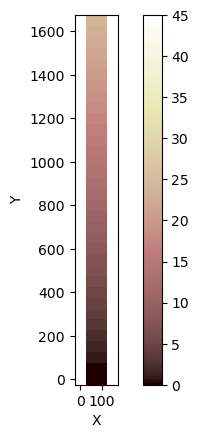

In [6]:
imshow_grid(rmg, "topographic__elevation", vmin=0, vmax=45)

Now, let's instantiate the OverlandFlow component. Instead of using a discharge we will use a rainfall intensity that results in a flow discharge of 1 m^3/s

In [7]:
of = OverlandFlow(
    rmg,
    h_init=0.001,
    mannings_n=n,
    rainfall_intensity=0.0,
)
of._rainfall_intensity = np.zeros_like(z, dtype=float)
of._rainfall_intensity[in_n] = 0.02  # Boundary conditions of discharge and flow depth

Now it is time to instantiate the RiverBedDynamics component, to check the required fields we do:

In [8]:
RiverBedDynamics.input_var_names

('surface_water__depth', 'surface_water__velocity', 'topographic__elevation')

We need to create or make sure that these fields exist: 
'surface_water__depth'
'surface_water__velocity'
'topographic__elevation'

Notice that 'topographic__elevation' was already created. In this case, 'surface_water__depth' appears again, but we should verify if it defined in links or nodes. Also, 'surface_water__velocity' has to be created. We can use RiverBedDynamics.var_mapping to check where these variables are mapped.

In [9]:
RiverBedDynamics.var_mapping

(('surface_water__depth', 'link'),
 ('surface_water__velocity', 'link'),
 ('topographic__elevation', 'node'))

We have 'surface_water__depth' and 'topographic__elevation' at nodes. Therefore, we will map 'surface_water__depth' to links and create 'surface_water__velocity'

In [10]:
rmg.add_zeros("surface_water__velocity", at="node")
rmg.add_zeros("surface_water__velocity", at="link")
rmg["link"]["surface_water__depth"] = map_mean_of_link_nodes_to_link(
    rmg, "surface_water__depth"
)

We set boundaries as closed boundaries, the outlet is set to an open boundary

In [11]:
rmg.set_watershed_boundary_condition_outlet_id([1, 2], z, 45.0)

Before instantiating RiverBedDynamics, we need to specify for this case the sediment transport and bed elevation boundary conditions. These are optional fields, that is why they are not listed as mandatory. We will use the bed_surface__elevation_fixed_node and sediment_transport__sediment_supply_imposed_link optional fields. First we create these fields.

In [12]:
# Creates optional fields that will be used in the simulation
# fixed_nodes defines as 1 if a node is fixed or 0 if it can varies in elevation
fixed_nodes = np.zeros_like(z)
fixed_nodes[fixed_nodes_id] = 1  # Assigns 1 to fixed nodes, all the others are zero.

# sediment_transport__sediment_supply_imposed
qb = np.full(rmg.number_of_links, 0.0)
qb[in_l] = in_qb  # Previously defined - # bedload rate at inlet in m3/s

We will pass fixed_nodes and qb during instantiation.

In [13]:
rbd = RiverBedDynamics(
    rmg,
    gsd=gsd,
    outlet_boundary_condition="fixedValue",
    bed_surf__elev_fix_node=fixed_nodes,
    sed_transp__bedload_rate_fix_link=qb,
)

A little explanation of what we did for the watershed boundary condition. Our DEM represents a long watershed with a given slope in the central region. The outlet is in the south boundary, which according to landlab grid convention is defined as nodes 1 and 2 (that is why we have ...outlet_id([1,2]..., then z contains the bed surface elevation created when we did:
(rmg, z) = read_esri_ascii(bedElevation, name='topographic__elevation'), and 45 tells the component that if that value exist in the DEM it is an invalid value. Most commonly it is used as -9999.

Here we define some ghost cells. In this tutorial we are analyzing a 1500 m long reach, but the DEM contains data up to 1650 m. Outside 1500 m, where is the point in which the sediment supply is defined, the bed elevation is assumed to vary according to a zero gradient condition.

In [14]:
n_col = rmg.number_of_node_columns
n_row = rmg.number_of_node_rows

n_row_calc_n = int(calc_node_id.shape[0] / n_col)
calc_node_id = np.reshape(calc_node_id, (n_row_calc_n, n_col))

Before starting let's get the analytical solution

In [15]:
# Initial bed elevation in the study section
z0 = np.reshape(z, (n_row, n_col))[1:-2, 1]
z0 = copy.deepcopy(z0)

# D50 is constant everywhere in this case. Was converted to m
D50 = rbd._bed_surf__median_size_node[0] / 1000

# MPM bedload per unit width - Dimensionless
qbStar = np.abs(in_qb) / (np.sqrt(rbd._R * rbd._g * D50) * D50)

k1 = (np.abs(Q) * n / rmg.dx) ** (3 / 5)
k2 = k1 / (rbd._R * D50)
S = ((1 / k2) * ((qbStar / qbStar_coeff) ** (1 / qbStar_exp) + tauCrStar)) ** (10 / 7)
x = np.linspace(x0, xf, z0.shape[0])
zAnalytic = S * x

Let's run Overland flow for one day, such that when we use RiverBedDynamics water is already flowing across the landscape

In [16]:
progress0 = 0
while t0 < sim_max_t_0:
    of.overland_flow(dt=max_dt)  # Runs overland flow for one time step

    t0 += of.dt
    progress = int((t0 / sim_max_t_0) * 100)
    if progress > progress0 + 1:
        print("\r" + f"Getting initial conditions - Progress: [{progress}%]", end="")
        progress0 = progress

# Velocity at time zero
rmg["link"]["surface_water__velocity"] = (
    rmg["link"]["surface_water__discharge"] / rmg["link"]["surface_water__depth"]
)

Getting initial conditions - Progress: [100%]

Let's take a look at the topographic conditions and water depth in what will now be time zero.

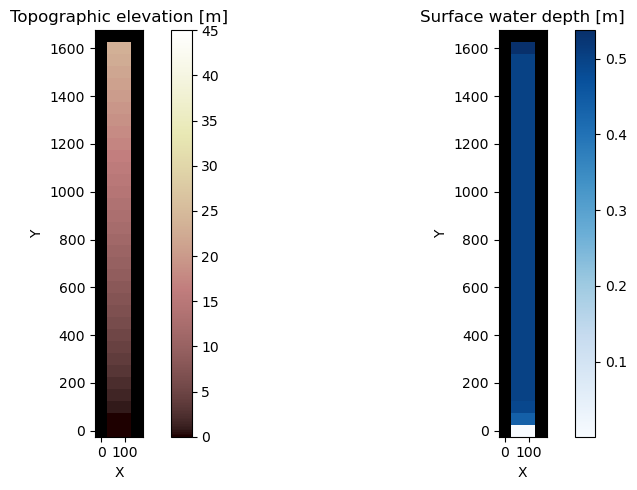

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.sca(axs[0])
imshow_grid(rmg, "topographic__elevation", vmin=0, vmax=45)
plt.title("Topographic elevation [m]")

plt.sca(axs[1])
imshow_grid(rmg, "surface_water__depth", cmap="Blues")
plt.title("Surface water depth [m]")

plt.tight_layout()
plt.show()

Before executing the main loop, let's define a function that will help us visualize the evolution of the bed elevation.

In [18]:
def plotCurrentBedState(z_evolution, t):
    zPrevious = z_evolution[1:-1, :]
    zCurrent = z_evolution[-1, :]

    # Clear the previous figure
    clear_output(wait=True)

    if zPrevious.shape[0] > 0:
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(x, z0, color="black", label="Initial Condition")

        # Plot zPrevious
        num_rows = zPrevious.shape[0]
        colors = cm.Greys(np.linspace(0.3, 0.7, num_rows))
        for row in zPrevious:
            ax.plot(
                x, row, color=colors[num_rows - 1]
            )  # plotting in grayscale without labels
            num_rows -= 1  # reduce the grayscale for next iteration

        # Plot zCurrent
        current_time = "Current time " + str(t) + " sec"
        ax.plot(x, zCurrent, color="tab:orange", label=current_time, linestyle="--")

        # Plot zAnalytic
        ax.plot(x, zAnalytic, color="blue", label="Analytical Solution")

        # Display legend
        ax.legend()
        ax.set_title("Elevation evolution")
        ax.set_xlabel("Streamwise distance [m]")
        ax.set_ylabel("Elevation [m]")
        ax.set_xlim(0, 1500)
        ax.set_ylim(0, 40)
        plt.tight_layout()

        # Display the current figure
        display(fig)

        # Close the figure to avoid unnecessary memory usage
        plt.close(fig)

Now, let's execute the loop that drives the simulation for both components:

In [19]:
# The simulation may take a long time to run,
# so we added a progress report
save_data_time_interval_original = copy.deepcopy(
    save_data_time_interval
)  # A copy of save_data_time_interval
z_evolution = rmg["node"]["topographic__elevation"][sample_node_id]
progress0 = 0
while t < sim_max_t:
    # Velocity at previous time
    rbd._surface_water__velocity_prev_time_link = (
        rmg["link"]["surface_water__discharge"] / rmg["link"]["surface_water__depth"]
    )

    # Runs overland flow for one time step
    of.overland_flow(dt=max_dt)

    # Velocity at current time
    rmg["link"]["surface_water__velocity"] = (
        rmg["link"]["surface_water__discharge"] / rmg["link"]["surface_water__depth"]
    )

    # Defines the time step used in RiverBedDynamics
    rbd._grid._dt = of.dt

    # Runs riverBedDynamics for one time step
    rbd.run_one_step()

    # Bed boundary condition
    for i in calc_node_id:
        rmg["node"]["topographic__elevation"][i] = rmg["node"][
            "topographic__elevation"
        ][i - n_col]

    ## Stores results
    save_data_time_interval = save_data_time_interval - of.dt
    if save_data_time_interval <= 0:
        z_evolution = np.vstack(
            [z_evolution, rmg["node"]["topographic__elevation"][sample_node_id]]
        )
        plotCurrentBedState(z_evolution, t)
        save_data_time_interval = save_data_time_interval_original

    t += of.dt
    progress = int((t / sim_max_t) * 100)
    if progress > progress0 + 1:
        print("\r" + f"Progress: [{progress}%]", end="")
        progress0 = progress

Progress: [100%]

Let's take a look at the new topography and the water depth field

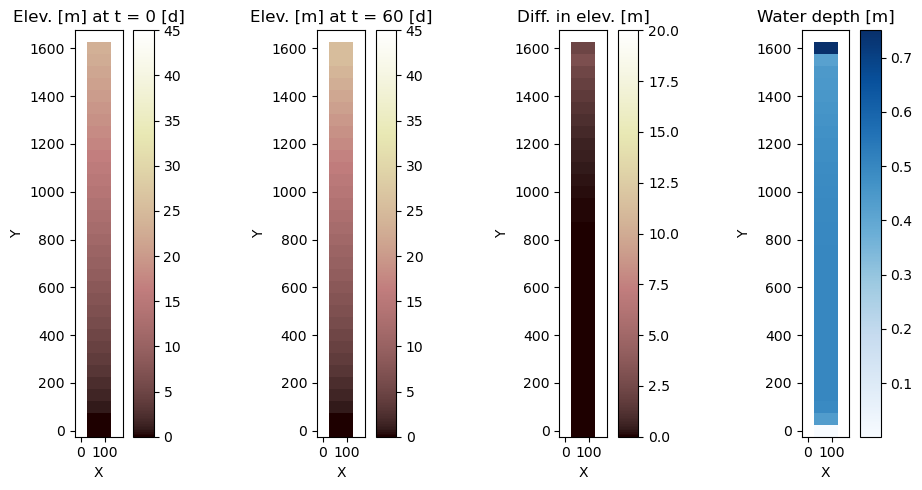

In [20]:
z = rmg["node"]["topographic__elevation"]
z0 = rmg["node"]["topographic__elevation_original"]
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

plt.sca(axs[0])
imshow_grid(rmg, z0, vmin=0, vmax=45, color_for_closed="None")
plt.title("Elev. [m] at t = 0 [d]")

plt.sca(axs[1])
imshow_grid(rmg, z, vmin=0, vmax=45, color_for_closed="None")
plt.title("Elev. [m] at t = 60 [d]")

plt.sca(axs[2])
diff_z = z - z0
imshow_grid(rmg, diff_z, vmin=0, vmax=20.0, color_for_closed="None")
plt.title("Diff. in elev. [m]")  # set a title

plt.sca(axs[3])
imshow_grid(rmg, "surface_water__depth", cmap="Blues", color_for_closed="None")
plt.title("Water depth [m]")

plt.tight_layout()
plt.show()

After 60 days, we can observe significant changes in the riverbed.

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>